In [1]:
from qick import *

import matplotlib.pyplot as plt
import numpy as np

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

##### Load FGPA BitStream
soc = QickSoc('./qick_4x2_spin.bit')
#soc = QickSoc('./qick_4x2_spin_w.bit')
soccfg = soc
for iTile in soc.dac_tiles:
    print("DAC tile %d locked: %s"%(iTile, soc.rf.dac_tiles[iTile].PLLLockStatus == 2))
for iTile in soc.adc_tiles:
    print("ADC tile %d locked: %s"%(iTile, soc.rf.adc_tiles[iTile].PLLLockStatus == 2))

print(soccfg)


DAC tile 0 locked: True
DAC tile 2 locked: True
ADC tile 0 locked: True
ADC tile 2 locked: True
QICK running on RFSoC4x2, software version 0.2.272

Firmware configuration (built Wed Jul 31 08:41:49 2024):

	Global clocks (MHz): tProcessor 552.960, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (14.815 us)
		fs=4423.680 MHz, fabric=276.480 MHz, 32-bit DDS, range=4423.680 MHz
		DAC tile 2, blk 0 is DAC_A
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (7.407 us)
		fs=8847.360 MHz, fabric=552.960 MHz, 32-bit DDS, range=8847.360 MHz
		DAC tile 0, blk 0 is DAC_B

	1 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by dport 0, pin 0, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D

	20 digital output pins:
	0:	PMOD0_0
	1:	PMOD0_1
	2:	PMOD0_2
	3:	PMOD0_3
	4:	PMOD0_4
	5:	PMO

In [2]:
# ZCU111
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 1000

  0%|          | 0/5 [00:00<?, ?it/s]

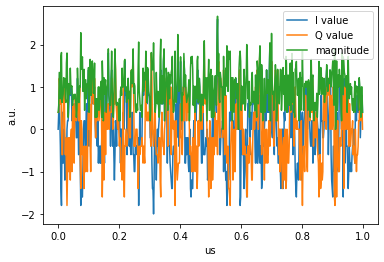

In [159]:
def sawtooth(length=1, maxv=30000, waves=1):
    print(length)
    length_wav = length*16/waves
    length_wav = int( length_wav - ( length_wav % 16 ) )
    print(length_wav)
    ramp = np.linspace(0, maxv, length_wav)
    y = []
    for ind in range(waves):
        y = np.append(y, ramp)
    return y

def sawtooth_2(length=1, maxv=30000, cycles=1):
    time = np.linspace(0, 1, length*16) * cycles
    sawtooth = maxv * (time - np.floor(time))
    sawtooth = sawtooth.astype(int)
    return sawtooth


class MyPulse(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        
        ## SAWTOOTH
        length = .1
        waves  = 10
        len_saw    = self.us2cycles(gen_ch=gen_ch, us=length)
        idata = sawtooth_2(len_saw, 32000, waves)
        self.add_envelope(ch=gen_ch, name="saw_env", idata=idata)

        ## GAUSS
        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="my_dds", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="my_env", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="saw_env",
                       outsel="input", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        
    def body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="my_env", t=0)
        #self.pulse(ch=cfg['gen_ch'], name="my_dds", t=0.3)
        #self.pulse(ch=cfg['gen_ch'], name="my_product", t=0.6)


GEN_CH = 0
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1,
         }


prog = MyPulse(soccfg, reps=1, final_delay=0.4, cfg=config)


iq_list = prog.acquire_decimated(soc, soft_avgs=5)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");



In [ ]:
print(soc)

In [ ]:
soc.config_clocks(1)
for iTile in soc.dac_tiles:
    print("DAC tile %d locked: %s"%(iTile, soc.rf.dac_tiles[iTile].PLLLockStatus == 2))
for iTile in soc.adc_tiles:
    print("ADC tile %d locked: %s"%(iTile, soc.rf.adc_tiles[iTile].PLLLockStatus == 2))

In [ ]:
for iTile in soc.dac_tiles:
    print("DAC tile %d locked: %s"%(iTile, soc.rf.dac_tiles[iTile].PLLLockStatus == 2))
for iTile in soc.adc_tiles:
    print("ADC tile %d locked: %s"%(iTile, soc.rf.adc_tiles[iTile].PLLLockStatus == 2))

In [ ]:
def add_triangle(self, ch, name, length, maxv=None, even_length=False):
        """Adds a triangle to the envelope library.
        The envelope will peak at length/2.
        Duration units depend on the program type: tProc v1 programs use integer number of fabric clocks, tProc v2 programs use float us.

        Parameters
        ----------
        ch : int
            generator channel (index in 'gens' list)
        name : str
            Name of the envelope
        length : int or float
            Total envelope length (in fabric clocks or us)
        maxv : float
            Value at the peak (if None, the max value for this generator will be used)
        even_length : bool
            If length is in us, round the envelope length to an even number of fabric clock cycles.
            This is useful for flat_top pulses, where the envelope gets split into two halves.
        """
        gencfg = self.soccfg['gens'][ch]
        if maxv is None: maxv = gencfg['maxv']*gencfg['maxv_scale']
        samps_per_clk = gencfg['samps_per_clk']

        # convert to integer number of fabric clocks
        if self.USER_DURATIONS:
            if even_length:
                lenreg = 2*self.us2cycles(gen_ch=ch, us=length/2)
            else:
                lenreg = self.us2cycles(gen_ch=ch, us=length)
        else:
            lenreg = np.round(length)
        # convert to number of samples
        lenreg *= samps_per_clk

        self.add_envelope(ch, name, idata=triang(length=lenreg, maxv=maxv))



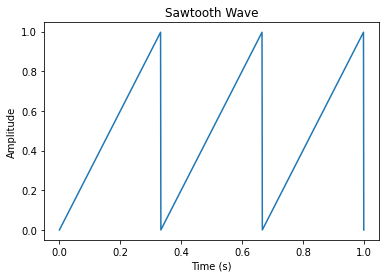

In [94]:
def sawtooth_2(length=1, maxv=30000, cycles=1):
    time = np.linspace(0, maxv, length) * cycles
    sawtooth = maxv * (time - np.floor(time))
    return sawtooth

# Define the parameters of the sawtooth wave
amplitude = 1.0  # Amplitude of the wave
frequency = 3.0  # Frequency of the wave in Hz
duration = 1.0   # Duration of the wave in seconds

# Generate the time values for the x-axis
sampling_rate = 1000  # Number of samples per second
num_samples = int(sampling_rate * duration)
time = np.linspace(0, duration, num_samples)

# Generate the y-values for the sawtooth wave
cycles = frequency * time
sawtooth = amplitude * (cycles - np.floor(cycles))

import numpy as np
import matplotlib.pyplot as plt

# Define the parameters of the sawtooth wave
amplitude = 1.0  # Amplitude of the wave
frequency = 3.0  # Frequency of the wave in Hz
duration = 1.0   # Duration of the wave in seconds

# Generate the time values for the x-axis
sampling_rate = 1000  # Number of samples per second
num_samples = int(sampling_rate * duration)
time = np.linspace(0, duration, num_samples)

# Generate the y-values for the sawtooth wave
cycles = frequency * time
sawtooth = amplitude * (cycles - np.floor(cycles))

# Plot the sawtooth wave
plt.plot(time, sawtooth)

# Set the plot title and labels for the x and y axes
plt.title('Sawtooth Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Show the plot
plt.show()

In [ ]:
        self.add_pulse(ch=gen_ch, name="my_product", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="saw_env", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

[ 0  0  0 ... 99 99  0]


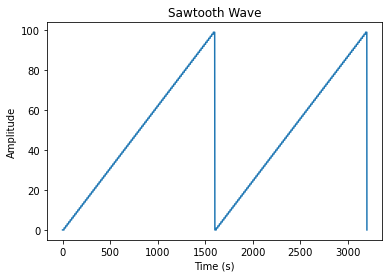

In [141]:
def sawtooth_2(length=1, maxv=30000, cycles=1):
    time = np.linspace(0, 1, length*16) * cycles
    sawtooth = maxv * (time - np.floor(time))
    sawtooth = sawtooth.astype(int)
    return sawtooth


saw = sawtooth_2(200, 100, 2)
print(saw)
# Plot the sawtooth wave
plt.plot(saw)

# Set the plot title and labels for the x and y axes
plt.title('Sawtooth Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Show the plot
plt.show()